In [0]:
## import libraries ##
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Dropout
#from keras.regularizers import dropout
from keras.models import Model,load_model
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
import keras
import keras.backend as K
from tensorflow import keras
from sklearn.model_selection import train_test_split
K.set_image_data_format("channels_last")
tf.random.set_seed(42)

In [0]:
## Load dataset cifar-10 ## 

(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

Corresponding label : [6]


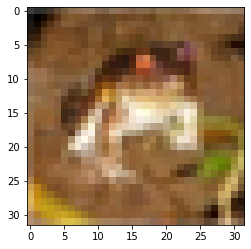

Corresponding label : [9]


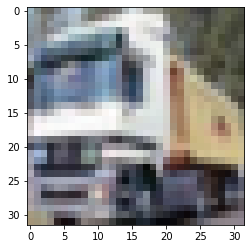

Corresponding label : [9]


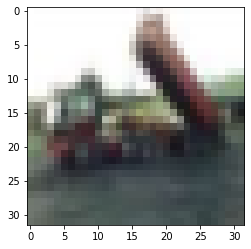

In [0]:
## Display some images with labels
for i in range(3):
    print("Corresponding label : {}".format(train_labels[i]))
    plt.imshow(train_images[i])
    plt.show()

In [0]:
## height,width,channel of images, Number of examples in the training/test datasets 


print("Number of examples -- Training datasets --: " , train_images.shape[0] )
print("Number of examples -- Test datasets -- " , test_images.shape[0])
print('Number of images in -- all the datasets --: ' , len(train_images) + len(test_images))
print('Training images shape : ', train_images.shape)
print('Test images shape : ', test_images.shape)
print("Size Height : ", train_images.shape[1])
print("Size Width :" , train_images.shape[2])
print("Number of channels : ", train_images.shape[3])

Number of examples -- Training datasets --:  50000
Number of examples -- Test datasets --  10000
Number of images in -- all the datasets --:  60000
Training images shape :  (50000, 32, 32, 3)
Test images shape :  (10000, 32, 32, 3)
Size Height :  32
Size Width : 32
Number of channels :  3


In [0]:
## Number of classes in the datasets 

classes = set(train_labels.flatten())

print("Number of classes in the datasets : " , len(classes))
print("Labels in the datasets : ", list(classes))


Number of classes in the datasets :  10
Labels in the datasets :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [0]:
# Number of images for each class  ##
dict_labels = dict(zip(*np.unique(train_labels,return_counts = True)))
for key,value in dict_labels.items():
    print("Label : {}".format(key) + " <--> " + "Number of images : {}".format(value))

Label : 0 <--> Number of images : 5000
Label : 1 <--> Number of images : 5000
Label : 2 <--> Number of images : 5000
Label : 3 <--> Number of images : 5000
Label : 4 <--> Number of images : 5000
Label : 5 <--> Number of images : 5000
Label : 6 <--> Number of images : 5000
Label : 7 <--> Number of images : 5000
Label : 8 <--> Number of images : 5000
Label : 9 <--> Number of images : 5000


In [0]:
## Normalize data to speed up training 
train_images = train_images.astype("float32") /255.0
test_images = test_images.astype("float32") / 255.0

In [0]:
train_labels[0]

array([6], dtype=uint8)

In [0]:
X_train,X_val,Y_train,Y_val = train_test_split(train_images,train_labels,test_size = 0.2 , random_state = 42)

Images after normalization : 
Corresponding label : [6]


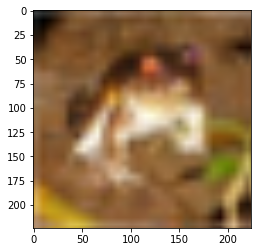

Corresponding label : [9]


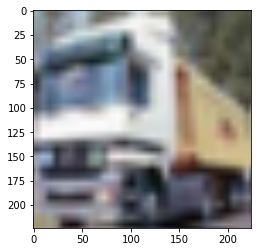

Corresponding label : [9]


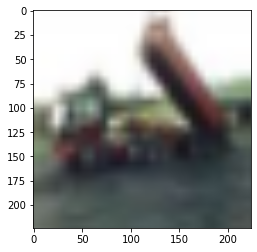

In [0]:
print("Images after normalization : ")
for i in range(3):
    print("Corresponding label : {}".format(train_labels[i]))
    plt.imshow(resize(train_images[i],(224,224,3)))
    plt.show()

In [0]:
from keras.initializers import glorot_uniform
initializer = "glorot_uniform"

In [0]:
## Implementing  the identity block (first block type)  ##

def identity_block(X,f,filters,stage,block):
    F1,F2,F3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    X_shortcut = X
    
    ### Implementation of the main path ### --> 3 component
    
    ## First Component ##
    X = Conv2D(F1 , kernel_size = (1,1) , strides = (1,1) , padding = "valid",name = conv_name_base + '2a',kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = -1,name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ## Second component ##
    ## the middle Conv layers window in the main path is given on the parameters
    X = Conv2D(F2 ,kernel_size = (f,f),strides = (1,1) ,padding = "same",name = conv_name_base + '2b',kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = -1 , name = bn_name_base + "2b")(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    
    ## Third component ## 
    X = Conv2D(F3 , kernel_size = (1,1) ,strides = (1,1) , padding = "valid" , name = conv_name_base + "3c",kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = -1 , name = bn_name_base + "3c")(X)
    
    ## Adding X_shortcut to the third component ## 
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X   
    

In [0]:
## Implementing the convolutional block (second block type) ##

def conv_block(X,f,filters,stage,block ,s = 2):
    F1,F2,F3 = filters
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"
    
    X_shortcut = X
    
    ## First component of the main path ##
    X = Conv2D(F1 , kernel_size = (1,1) , strides = (s,s)  , name = conv_name_base + '2a' , kernel_initializer =initializer)(X)
    X = BatchNormalization(axis = -1,name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ## Second component of the main path ##
    X = Conv2D(F2 , kernel_size = (f,f) , strides = (1,1) , padding = "same" , name = conv_name_base + '2b',kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = -1,name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Dropout(0.3)(X)
    
    ## Third Component of the main path ## 
    
    X = Conv2D(F3 , kernel_size = (1,1) , strides = (1,1) , padding = "valid" , name = conv_name_base + '2c',kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = -1,name = bn_name_base + '2c')(X)
    
    ## Shortcut path ##
    X_shortcut = Conv2D(F3,kernel_size = (1,1) , strides = (s,s) , padding = "valid" , name = conv_name_base + "1",kernel_initializer = initializer)(X_shortcut)
    X_shortcut = BatchNormalization(axis = -1,name = bn_name_base + "1")(X_shortcut)
    
    ## Finally add shortcut path output and main path output
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
## Implementation ResNet-50 ## 
## There are 5 stages 
## Adding residual blocks, allow us to train much deeper NN
## In resNet , even the network is deeper the model has a good fit for the training data
def ResNet50(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D(padding = (3,3))(X_input)
    
    ## Stage 1 ## 
    
    X = Conv2D(64,kernel_size = (7,7) , strides = (2,2) , name ="conv1")(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (3,3) , strides = (2,2))(X)
    X = Dropout(0.2)(X)
    
    
    ## Stage 2 ## 
    
    X = conv_block(X,f = 3,filters = [64,64,256],stage = 2,block = "a", s = 1)
    X = identity_block(X,f = 3,filters = [64,64,256],stage = 2,block = "b")
    X = identity_block(X,f = 3,filters = [64,64,256],stage = 2,block = "c")
    
    ## Stage 3 ## 
    
    X = conv_block(X,f = 3,filters = [128,128,512],stage = 3,block = "a", s = 2)
    X = identity_block(X,f = 3,filters = [128,128,512],stage = 3,block = "b")
    X = identity_block(X,f = 3,filters = [128,128,512],stage = 3,block = "c")
    X = identity_block(X,f = 3,filters = [128,128,512],stage = 3,block = "d")
    
    ## Stage 4 ## 
    
    X = conv_block(X,f = 3,filters = [256,256,1024],stage = 4,block = "a", s = 2)
    X = identity_block(X,f = 3,filters = [256,256,1024],stage = 4,block = "b")
    X = identity_block(X,f = 3,filters = [256,256,1024],stage = 4,block = "c")
    X = identity_block(X,f = 3,filters = [256,256,1024],stage = 4,block = "d")
    X = identity_block(X,f = 3,filters = [256,256,1024],stage = 4,block = "e")
    X = identity_block(X,f = 3,filters = [256,256,1024],stage = 4,block = "f")
    
    
    ## Stage 5 ## 
    
    X = conv_block(X,f = 3 , filters = [512, 512, 2048] , stage = 5,block = "a" , s = 2)
    X = identity_block(X,f = 3,filters = [512, 512, 2048],stage = 5,block = "b")
    X = identity_block(X,f = 3,filters = [512, 512, 2048],stage = 5,block = "c")
    
    #print(X.shape)
    ## output here is 1x1x2048
    ## Averagepool in this case do not have effect
    
    
    X = AveragePooling2D(pool_size = (1,1) , name = "avg_pool")(X)
    
    #print("After pooling ",X.shape)
    ## Flatten the output X ##
    
    X = Flatten()(X)
    
    X = Dense(classes,activation = 'softmax' , name = "fc" + str(classes))(X)
    
    
    model = Model(inputs = X_input , outputs = X , name = "ResNet50")
    
    return model
    

In [0]:
model = ResNet50(input_shape = (32,32,3) , classes = 10)

In [0]:
## Compile the model

callback = tf.keras.callbacks.EarlyStopping(monitor= "loss" , patience = 5)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= 1e-2,decay_steps= 1000,decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy" , metrics = ["accuracy"])

In [0]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 38, 38, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_16[0][0]          
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
## Function that compute the one-hot representation of an integer tensor
def convert_to_one_hot(Y,C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [0]:
## Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train,10).T
Y_test = convert_to_one_hot(test_labels,10).T
Y_val = convert_to_one_hot(Y_val,10).T


In [0]:
from keras.preprocessing.image import ImageDataGenerator
## TOMORROW ADD MORE EPOCH ! ## + Regularizer L2 to reduce variance

In [0]:

gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=64 , shuffle = True)
val_batches = gen.flow(X_val, Y_val, batch_size=64 , shuffle = True )

In [35]:
history  = model.fit_generator(generator = batches,validation_data = val_batches , epochs = 100  , callbacks = [callback])

Epoch 1/100
625/625 [==============================] - 68s 108ms/step - loss: 3.0242 - accuracy: 0.1813 - val_loss: 3.0299 - val_accuracy: 0.1218
Epoch 2/100
625/625 [==============================] - 59s 94ms/step - loss: 1.8412 - accuracy: 0.3142 - val_loss: 2.1108 - val_accuracy: 0.3420
Epoch 3/100
625/625 [==============================] - 59s 94ms/step - loss: 1.6194 - accuracy: 0.3969 - val_loss: 2.4505 - val_accuracy: 0.4218
Epoch 4/100
625/625 [==============================] - 59s 94ms/step - loss: 1.5027 - accuracy: 0.4496 - val_loss: 1.8519 - val_accuracy: 0.4007
Epoch 5/100
625/625 [==============================] - 59s 94ms/step - loss: 1.5250 - accuracy: 0.4444 - val_loss: 2.4438 - val_accuracy: 0.3077
Epoch 6/100
625/625 [==============================] - 59s 94ms/step - loss: 1.4855 - accuracy: 0.4548 - val_loss: 1.7795 - val_accuracy: 0.4549
Epoch 7/100
625/625 [==============================] - 60s 96ms/step - loss: 1.4575 - accuracy: 0.4689 - val_loss: 1.7629 - val_a

In [36]:
pred = model.evaluate(test_images,Y_test)
print("Loss : "  + str(pred[0]))
print("Accuracy : " + str(pred[1]))

10000/10000 [==============================] - 5s 541us/step
Loss : 0.6783697756767273
Accuracy : 0.8079000115394592


Text(0.5, 1.0, 'Training and Validation Loss')

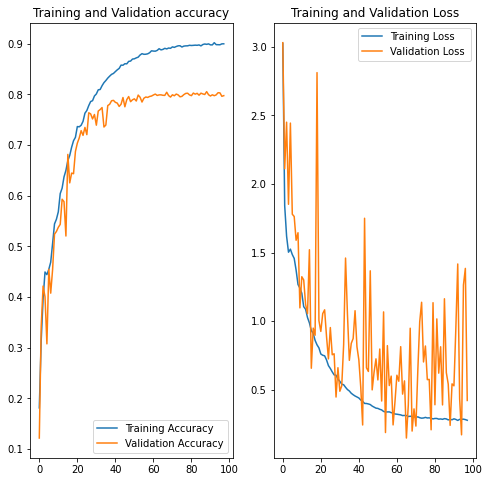

In [37]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epoch_range = range(98)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range,acc,label = "Training Accuracy")
plt.plot(epoch_range,val_acc , label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation accuracy")


plt.subplot(1,2,2)
plt.plot(epoch_range,loss,label = "Training Loss")
plt.plot(epoch_range,val_loss,label = "Validation Loss ")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")